# A/B Testing - Sequential Testing

## Background

When running an A/B test we typically decide on its __runtime in advance__ by considering results from a power analysis and most likely additional external factors (e.g. measurement of long-term effects). Even though monitoring dashboards are almost always in place to inform all stakeholders involved with an experiment's ongoing performance, we need to be __careful with continuously testing__ each group against the other. The reason for this is that multiple testing can __inflate the type I error rate__ ($\alpha$-error). Simply by repeating the comparison of our null hypothesis $H0$ against our alternative $H1$ we will increase the probability of a particular outcome even if this outcome is very unlikely. In fact, the experiment-wise error rate which represents the overall error rate over a series of tests is going increase from $\alpha$ to $1 − (1−\alpha) * n$ where $n$ is the number of individual tests. Thus, in order to maintain an A/B test's significance level of e.g. $\alpha = .05$ one has to be much more conservative at each individual test. Among others this notebook covers __two different approaches__ on how to do multiple testing (and early stopping) correctly:

- [Group Sequential Designs](#Group-Sequential-Designs)
- [Mixture Sequential Probability Ratio Tests (mSPRT)](#Mixture-Sequential-Probability-Ratio-Test-(mSPRT))

## Group Sequential Designs

Group sequential test designs were first developed in the context of clinical trials where ethical reasons require researchers to continously monitor experiments and stop them early when possible. In order to __control for an inflating $\alpha$-error rate__ of multiple tests, group sequential designs use a technique called __error-spending functions__. Under the assumption of normality, a spending functions estimates an adjusted test statistic for each stage of the experiment so that the overall $\alpha$-error level is maintained. The series of test statistics represents an upper/lower decision boundary in a one-sided test i.e. represents both in a two-sided test.

The most simple spending function spreads the error rate evenly over the different testing times and results in constant, so-called Pocock type decision boundaries. This approach follows the assumption that all data collected during an experiment is evenly distributed between testing times. Unfortunately, this assumption is not met most of the times, especially not within an online environment where traffic varies widely and users are not distinct between one day and the other. A more appropriate alternative, first developed by [Lan & DeMets (1983)](https://eclass.uoa.gr/modules/document/file.php/MATH301/PracticalSession3/Lan_DeMets_1983.pdf), is to __spend the error according to the fraction of information gathered__ at time of analysis. Despite that, we may wish to be more conservative in early stages of an A/B test, thus use much wider decision boundaries (which require much smaller p-values of individual tests in order to stop early) than towards the end. Two types of decision boundaries which fullfill such criteria can be achieved by using an [O’Brien-Fleming-type error spending function](https://eclass.uoa.gr/modules/document/file.php/MATH301/PracticalSession3/Lan_DeMets_1983.pdf) or a [Hwang-Shih-DeCani-type gamma error spending function](https://onlinelibrary.wiley.com/doi/abs/10.1002/sim.4780091207) with $\gamma = −4$, whereas the latter is a generalization to the former.

In order to __derive decision boundaries__ for a sequential analysis of an A/B test we need to follow a couple of different steps:
1. __Power analysis__ to estimate a tests minimum sample size and runtime
2. Definition of __group sequential design__
    1. Decision on __number of individual tests__ to run
    2. Anaysis of expected __relative traffic between individual tests__ (as cumulated percentage that sums up to one)
    3. Estimation of adjusted __test statistics__ i.e $z$-scores for lower and/or upper decision boundaries

Luckily, a bunch of smart people have already done most of the heavy lifting for us and put most of the complex calculations into ```R``` __libraries__ such as ```pwr``` for running power analyses and ```gsDesign``` for decision boundary computations. In order to illustrate how these steps look in detail we imagine an A/B test on max. 10% of whatever user base in which the implementation of a new feature aims to convert more users to doing something cool. 

### Power Analysis

Similar to any other A/B test we start out by estimating the minimum required sample size and runtime by doing a power analysis.

In [3]:
# Load libraries
require(pwr)

# Plug-in proxy for 'small' effect size ...
effect_size <- 0.01

# Estimate sample size n1 for first sample
n1 <- pwr.2p.test(
    h = effect_size,
    sig.level = 0.05,
    power = 0.8,
    alternative = 'two.sided'
)$n
ceiling(n1)

[1] 156978

Next, we'll need to figure out __how long it will approximately take until we've observed this many users__ in a single group. In the A/B test example we are simply going to look how the number of unique users of the old feature accumulates over time and then multiply this number by .1 to match the maximum size of our test group.

In [20]:
# Create dataframe with toy data
weeks <- c(seq(23,31,1))
users <- c(506456,784703,999654,1190597,1377913,1533096,1664629,1776549,1882559)
obs <- data.frame(weeks, users)
names(obs) <- c("week","n_users")

# Preview data
obs

[1] 23 24 25 26 27 28 29 30 31

In [21]:
# Maximum test group ratio of user base
test_share <- 0.1

# Compare adjusted number of senders
ceiling(obs$n_users * test_share)

[1]  50646  78471  99966 119060 137792 153310 166463 177655 188256

As we only pass the required number of users of 156.978 in week 7, we now know that our test needs to run at least 7 weeks before we can be certain to declare even a very small difference between test and control groups significant.

### Definition of Design

Now that we know how long our A/B test needs to run we can decide on __how many intermediate tests__ should be done. One way to approach this question is to use the minimum required runtime as guidance. In our example we need to have the test running for a minimum of 7 weeks. So in order to speed up things we could decide to do one intermediate test after every week and if we're lucky the difference between both groups is large enough to stop the test early. Despite that, we saw above that the __number of unique users does not always scale linearly__ with time and we need to control for this in our group sequential design.

The most __important parameters__ to specify for our group sequential design based on the ```gsDesign``` library are as follows:
- __test.type:__ 1 = One-sided; 2 = Two-sided (symmetric)
- __alpha:__ Type I error (e.g. 0.025 for overall type I error rate of 0.05 in two-sided test)
- __beta:__ Type II error (e.g. 0.2 for power of 1 - 0.2 = 0.8)
- __k:__ Number of tests
- __n.fix:__ Number of observations for both groups (input from power analysis)
- __timing:__ Time between tests as a normalized sequence that sums up to 1 (e.g. t2 = 0.4 means the second interim analysis includes the first 40% of planned observations)
- __sfu:__ Spending function (e.g. sfLDOF for conservative Lan-DeMets spending function with O'Brien-Fleming bounds)

For more information on (additional) parameters please use ```?gsDesign``` or refer to ```gsDesign``` [vignette](https://r-forge.r-project.org/scm/viewvc.php/*checkout*/pkg/gsDesign/inst/doc/gsDesignManual.pdf?revision=124&root=gsdesign).

One of the parameters outlined above still needs a bit thinking before we can finally come up with the first deisgn and that's __timing__. Timing represents a normalized sequence of cumulative user counts over the runtime of an experiment. What that exactly means becomes much clearer when looking at the numbers from our example:

In [22]:
# Expected cumulated unique user counts over the course of the experiment
n_users <- obs$n_users[1:7]

# Normalized sequences of above counts so they sum up to 1
n_users_nrmd <- n_users / max(n_users)

# Print results
cbind(n_users, n_users_nrmd)

n_users,n_users_nrmd
506456,0.3042456
784703,0.4713981
999654,0.6005266
1190597,0.7152326
1377913,0.8277598
1533096,0.9209836
1664629,1.0000000


Finally, we can __plug in the required parameter values__ in the ```gsDesign()``` function. For this we use a two-sided test with an overall type I error rate of .5 and power of .8. Error spending is based a Lan-DeMets spending function with O'Brien-Fleming bounds. Recall, these type of bounds are much more conservative in the beginning of the test.

In [10]:
# Load libraries
require(gsDesign)

# gsDesign object for two-sided test based on conservative Lan-DeMets
# spending function with O'Brien-Fleming bounds
design <- gsDesign(
    test.type = 2, alpha = 0.025, beta = 0.2,
    n.fix = 2*ceiling(n1), k = 7, timing = n_users_nrmd,
    sfu = sfLDOF
)
design

Symmetric two-sided group sequential design with
80 % power and 2.5 % Type I Error.
Spending computations assume trial stops
if a bound is crossed.

                 
  Analysis     N   Z   Nominal p  Spend
         1  99273 3.90    0.0000 0.0000
         2 153813 3.07    0.0011 0.0010
         3 195946 2.70    0.0035 0.0027
         4 233374 2.47    0.0068 0.0042
         5 270090 2.29    0.0111 0.0057
         6 300508 2.17    0.0149 0.0058
         7 326290 2.09    0.0182 0.0055
     Total                       0.0250 

++ alpha spending:
 Lan-DeMets O'brien-Fleming approximation spending function.

Boundary crossing probabilities and expected sample size
assume any cross stops the trial

Upper boundary (power or Type I Error)
          Analysis
  Theta      1      2      3      4      5      6      7 Total     E{N}
  0.000 0.0000 0.0010 0.0027 0.0042 0.0057 0.0058 0.0055 0.025 323472.5
  0.005 0.0101 0.1247 0.1854 0.1734 0.1468 0.0958 0.0638 0.800 251501.0

Lower boundary (futility

As you can see from the output above the benefit of testing sequentially comes at the cost of a __slighty increased sample size__. Instead of 156.978 users per group the design needs 326.290 / 2 = 163.145 (+4%) instead.

Last, but not least, we __plot the decision boundaries__ for our sequential design.

In [11]:
# Store results in data.frame
test_bounds <- data.frame(
    time = seq(1, design$k, by=1),
    zero = array(0, dim=design$k),
    lower = design$lower$bound,
    upper = design$upper$bound,
    stringsAsFactors = FALSE
)
test_bounds

# Convert to long format
test_bounds_long <- melt(test_bounds, id = "time")

time,zero,lower,upper
1,0,-3.898838,3.898838
2,0,-3.067407,3.067407
3,0,-2.698873,2.698873
4,0,-2.466512,2.466512
5,0,-2.286500,2.286500
6,0,-2.173505,2.173505
7,0,-2.092822,2.092822


ERROR: Error in melt(test_bounds, id = "time"): could not find function "melt"


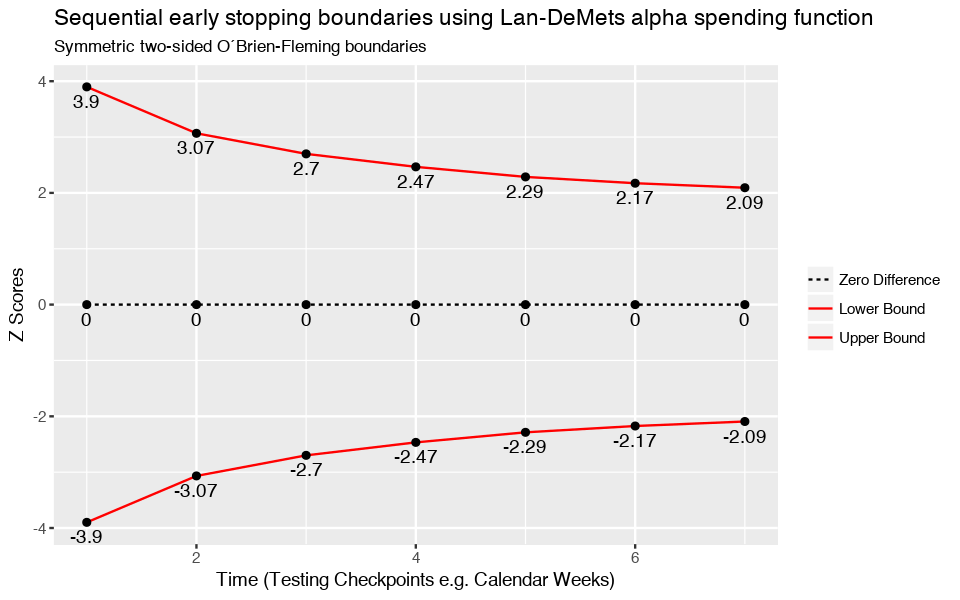

In [288]:
# Load libraries
require("reshape2")
require("ggplot2")
require('repr')

# Change plot size
options(repr.plot.width=8, repr.plot.height=5)

# Plot
labels <- c("Zero Difference", "Lower Bound", "Upper Bound")
bounds_plot <- ggplot(data = test_bounds_long, aes(x = time, y = value, group = variable)) +
       geom_line(aes(linetype=variable, color=variable)) + 
       scale_linetype_manual(values = c("dashed", "solid", "solid"), labels = labels) +
       geom_point() + geom_text(aes(label = round(value,2)), hjust = .5, vjust = 1.5) +
       scale_color_manual(values = c("black", "red", "red"), labels = labels) +
       labs(title = 'Sequential early stopping boundaries using Lan-DeMets alpha spending function', subtitle = 'Symmetric two-sided O´Brien-Fleming boundaries') +
       xlab('Time (Testing Checkpoints e.g. Calendar Weeks)') + 
       ylab('Z Scores') +
       theme(legend.title=element_blank())

bounds_plot

With upper and lower decision boundaries in place we're now able to test for differences between test and control groups on a weekly basis over the course of our experiment. As __boundaries are given by $z$-scores__ we need to make sure not to compare apples to oranges thus __run intermediate tests as $z$-tests__ as well. The value of $z$ can be calculated at each step as follows:

__Continious Outcomes:__

\begin{equation*}
 z = \frac{\mu_1 - \mu_2}{\sqrt{\frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_2}}}
\end{equation*}

__Proportions:__

\begin{equation*}
 z= \frac{p1 - p2}{\sqrt{\frac{1}{n_1}p_1(1-p_1) + \frac{1}{n_2}p_2(1-p_2)}}
\end{equation*}


While the value of $z$ is easy to calculate for proportions we typically run into an __issue of an unknown population standard deviation__ $\sigma$ for continuous outcomes. However, unless we only have tiny amounts of data we will simply plug in values from our samples. If you don't want to calculate values for $z$ by hand you can the ```z.test()``` function from the ```BSDA``` library.

In [13]:
# Example usage of z.test()
require('BSDA')

# Define groups
a <- c(rep(1, 300), rep(0, 8927-300))
b <- c(rep(1, 278), rep(0, 8898-278))

# Run test
z.test(a, b, alternative = "two.sided", sigma.x = sd(a), sigma.y = sd(b), conf.level = 0.95)


	Two-sample z-Test

data:  a and b
z = 0.89054, p-value = 0.3732
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.002837559  0.007563436
sample estimates:
 mean of x  mean of y 
0.03360591 0.03124298 


### Adjustment of Timing

As the experiment starts running and we have observations coming in it's not unusual that the __timing and number of analysis may change__. Let's say we observe 5% less users than expected after week 1 then we could use the following two parameters to adjust our testing plan: 

- __n.I:__ Actual number of observations at given sequential test (e.g. c(155, 1698, 1987) for three sequential tests)
- __maxn.IPlan:__ Original number of observations (should be passed if the sample size for the final analysis is changed)

In [343]:
# Show current and adjusted number of observations per interim analysis
cbind(
    design$n.I, # current
    c(design$n.I[1] * 0.95, design$n.I[-1]) # adjusted
)

99292.35,94327.74
153820.35,153820.35
195949.04,195949.04
233369.03,233369.03
270080.50,270080.50
300503.52,300503.52
326289.69,326289.69


In [344]:
# Adjust number of observations
n_adj <- c(design$n.I[1] * 0.95, design$n.I[-1])

# Adjust boundaries
design_adj <- gsDesign(
    test.type = 2, alpha = 0.025, beta = 0.2,
    k = 7, n.I = n_adj,
    # maxn.IPlan = 2*ceiling(n1) # <- only used if sample size of final analysis changed
    sfu = sfLDOF
)

# Compare initial to new boundaries
print('Initial boundaries:')
cbind(design$lower$bound, design$upper$bound)

print('Adjusted boundaries:')
cbind(design_adj$lower$bound, design_adj$upper$bound)

[1] "Initial boundaries:"


-3.898409,3.898409
-3.067324,3.067324
-2.698854,2.698854
-2.466546,2.466546
-2.286549,2.286549
-2.173513,2.173513
-2.092814,2.092814


[1] "Adjusted boundaries:"


-4.007884,4.007884
-3.065676,3.065676
-2.698711,2.698711
-2.466503,2.466503
-2.286531,2.286531
-2.173502,2.173502
-2.092807,2.092807


## Final Notes

### Symmetry of Tests
In the majority of experiments we attempt to observe an improvement over an existing solution. While discussions about the direction of an effect are typically centered around uplifts, we tend to forget that a variation can also show negative influence on the behavior of users. Thus, as we ask ourselves _'How much better does our variation have to be, to be practically significant?'_, we need to ask _'How much worse do we allow our variation to be, to be equivalent?'_, too. Whatever the answer might be, it should be considered in the decison on sequential stopping boundaries.

### Bias
Experiments that are stopped early tend to overestimate the true effect e.g. the true difference between test and control groups. This is simply due to the fact, that effect sizes need to be large when samples sizes are (still) small in order to reach statistical significance

## References
- [A Multiple Testing Procedure for Clinical Trials](ftp://maia-2.biostat.wisc.edu/pub/chappell/641/papers/paper34.pdf)
- [Discrete Sequential Boundaries for Clinical Trials](https://eclass.uoa.gr/modules/document/file.php/MATH301/PracticalSession3/Lan_DeMets_1983.pdf)
- [How to Do A/B Testing with Early Stopping Correctly](https://www.aarondefazio.com/adefazio-seqtesting.pdf)
- [How to Experiment Rapidly without Losing Rigour](https://deliveroo.engineering/2018/10/22/how-to-experiment-rapidly-without-losing-rigour.html)
- [Interim Analysis: The Alpha Spending Function Approach](https://eclass.uoa.gr/modules/document/file.php/MATH301/PracticalSession3/LanDeMets.pdf)
- [Multiple Hypothesis Testing and False Discovery Rate](https://www.stat.berkeley.edu/~hhuang/STAT141/Lecture-FDR.pdf)
- [Improving Experimentation Efficiency at Netflix](https://medium.com/netflix-techblog/improving-experimentation-efficiency-at-netflix-with-meta-analysis-and-optimal-stopping-d8ec290ae5be)
- [Wikipedia](https://en.wikipedia.org/wiki/Sequential_analysis)